# Video Demo

## Purpose
In this notebook, we will test the process of face recognition on videos.

# Setup

## Library import
We import all the required Python libraries.

In [26]:
# Core
import torch
from torch.utils.data import DataLoader
from torchvision import datasets

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import data_table
from PIL import Image
sns.set_theme(context='notebook', style='darkgrid', palette='pastel')

# General
import math
import os
from base64 import b64encode
from glob import glob
from IPython.display import HTML
from random import randint

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

## Repository import
We import all the required repositories. First of all, we need [timesler/facenet-pytorch](https://github.com/timesler/facenet-pytorch), which contains both the FaceNet model and the MTCNN module for detection and alignment.

In [2]:
%%bash
git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

Cloning into 'facenet_pytorch'...


We also import the file containing the method to annotate videos.

In [3]:
%%bash
wget https://raw.githubusercontent.com/AryaHassanli/Gendage/master/helpers/demo.py

--2020-10-26 13:41:30--  https://raw.githubusercontent.com/AryaHassanli/Gendage/master/helpers/demo.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3224 (3.1K) [text/plain]
Saving to: ‘demo.py’

     0K ...                                                   100% 48.1M=0s

2020-10-26 13:41:30 (48.1 MB/s) - ‘demo.py’ saved [3224/3224]



# Parameter definition
We set all relevant parameters for our notebook.

In [4]:
## General
# Set the device to a GPU if available.
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {DEVICE}')
# Set the number of workers depending on the os.
WORKERS = 0 if os.name == 'nt' else 4
print(f'N. of workers: {WORKERS}')

## InceptionResnetV1
# Defines whether to load a model pre-trained on `vggface2` or on
# `casia-webface`. The first one performs a little better (0.9965 on LFW
# compared to 0.9905) and is slightly smaller (107MB compared to 111MB).
PRETRAINED = "vggface2"

## MTCNN
# Define the output image size and margin of the MTCNN module.
IMAGE_SIZE = 160
MARGIN = 0


Running on device: cuda:0
N. of workers: 4



# Data import
We retrieve all the required data for the analysis. For the time being, the single video we are interested to analyze is the video of a video conference in which we appear.

In [5]:
%%bash
gdown https://drive.google.com/uc?id=1HHbSyrYhpnmH0XHnD7wnu6GanrXTlUvS -O rec.zip
unzip rec.zip
rm rec.zip
mv Recording.mp4 recording.mp4

Archive:  rec.zip
  inflating: Recording.mp4           


Downloading...
From: https://drive.google.com/uc?id=1HHbSyrYhpnmH0XHnD7wnu6GanrXTlUvS
To: /content/rec.zip
11.5MB [00:00, 31.5MB/s]


Moreover, we need an image for each one of the persons present in the video. The images were retrieve manually by the author from public sources.

In [6]:
%%bash
gdown https://drive.google.com/uc?id=1lFgXijt5OdaM6oSQKOdTruYzKG4z3QqN -O ids.zip
unzip ids.zip
rm ids.zip
mv Identities identities

Archive:  ids.zip
   creating: Identities/
  inflating: Identities/0_Alessandro_-1_m.jpg  
  inflating: Identities/1_Arya_-1_m.jpg  
  inflating: Identities/2_Levi_-1_m.jpg  
  inflating: Identities/3_Wei_-1_m.jpg  


Downloading...
From: https://drive.google.com/uc?id=1lFgXijt5OdaM6oSQKOdTruYzKG4z3QqN
To: /content/ids.zip
100%|##########| 179k/179k [00:00<00:00, 65.1MB/s]


# Data visualization
First of all, we visualize the video using HTML. For this purpose, we write a function that takes a path to a video and write an HTML piece.

In [ ]:
def show_video(path):
  # Open the file containing the recording and evaluate the data url.
  mp4 = open(path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

  # Print the video with HTML.
  return HTML("""<video width=400 controls>
                   <source src="%s" type="video/mp4">
                 </video>
              """ % data_url)

show_video('recording.mp4')

Moreover, we also write a function to print some of the frames in a video.

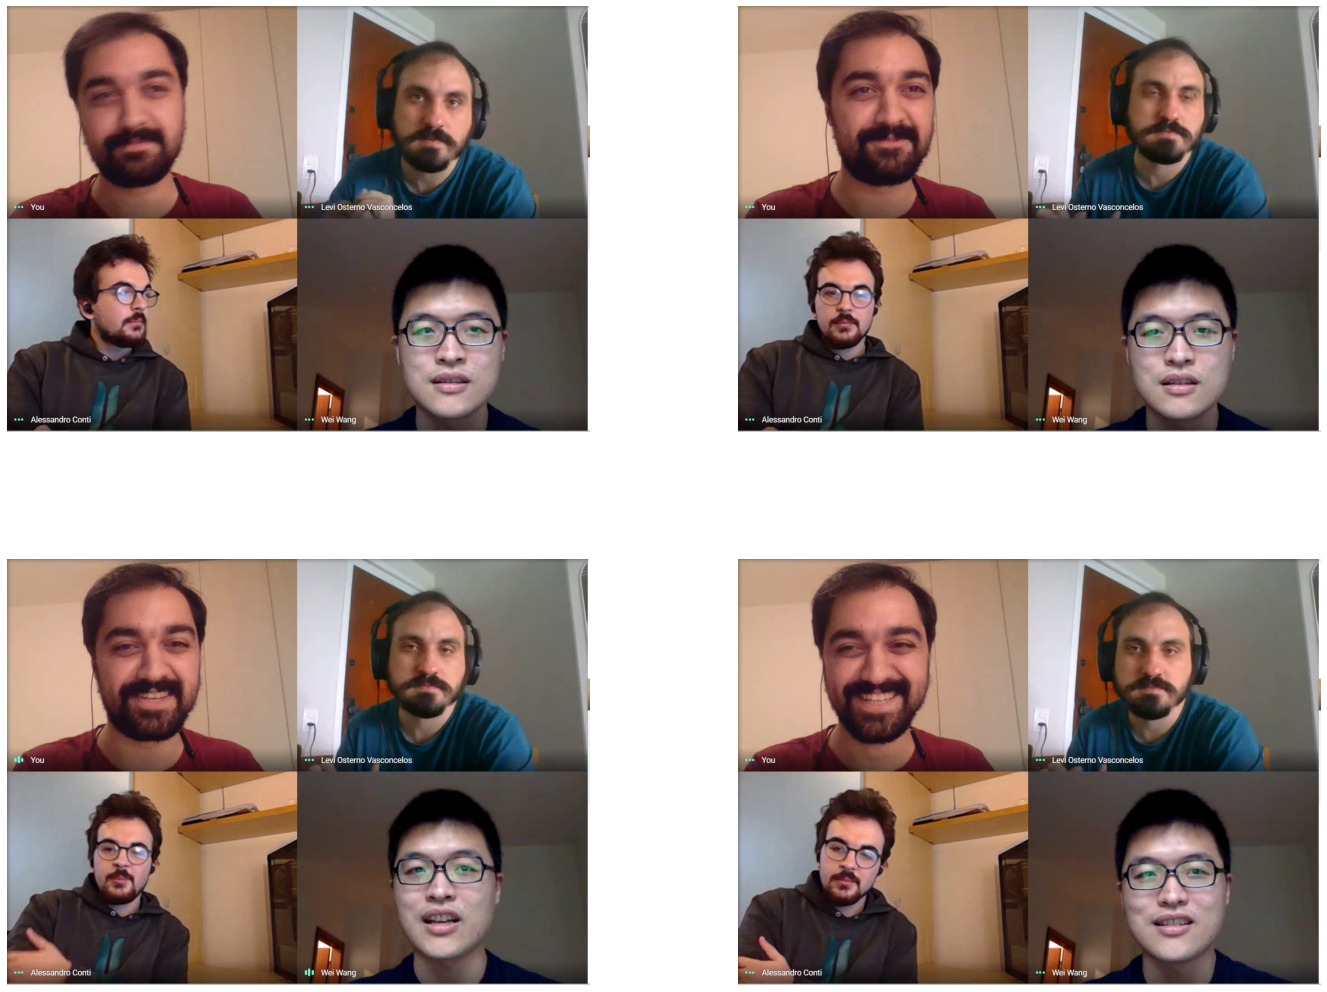

In [46]:
def show_frames(video, n=4, skip=30):
  """Show the first frames of a video.

    Arguments:
      n (int): total number of frames to show.
      video (string): path to the video.
      skip (int): number of frames to skip each print.
  """
  # Open the video.
  cap = cv2.VideoCapture(video)

  # Evaluate the size of the grid.
  size = math.ceil(math.sqrt(n))
  stop = n + 1

  # Create a new figure.
  fig = plt.figure(figsize=(size*12, size*9))

  # Set the horizontal space between subplots.
  plt.subplots_adjust(hspace=0.3)

  for i in range(1, stop):
    # Get the frame.
    for _ in range(skip):
      success, image = cap.read()

    # Convert the image from BGR to RGB.
    image = Image.fromarray(image.astype('uint8'))
    image = Image.merge("RGB", image.split()[::-1])

    if not success:
      continue

    # Add the image as a subplot.
    fig.add_subplot(size, size, i)
    plt.imshow(image)

    # Hide axis.
    plt.axis('off')

  # Show the plot.
  plt.show()

show_frames('recording.mp4')

Next, we write some functions to retrieve annotations and images. `get_annotations` returns the notes about an image given its path, `get_image` and `get_images` both return the path to an image given its `id`. Moreover, `get_images` can return also all the images of an identity.

In [8]:
def get_annotations(img_path):
  """Decompose the filename of an image to get its annotations.
  
    Arguments:
      img_path (string): Path to the image.
    
    Returns:
      annotations (list): Contains (in order) img_id, subject_name, age, gender.
  """
  # Keep only the filename and remove the directories.
  img_name = img_path.split('/')[-1]

  # Remove the extension.
  img_name = img_name[:-4]

  # Get the different notes by splitting on the underscore.
  fields = img_name.split('_')

  # Convert the img_id and the age to integer.
  fields = [int(fields[0]), fields[1], int(fields[2]), fields[3]]

  return fields

def get_image(id=-1):
  """Retrieve an image from the database. If no id is passed, then the image
  is taken at random.

    Arguments:
      id (int): id of the image.
    
    Returns:
      img_path (string): path to the image.
  """

  # Get the list of all of the images.
  images = glob('identities/*.jpg')

  # Check that the index valid.
  assert id <= len(images)

  # If no index, set it randomly.
  if id == -1:
    id = randint(0, len(images))

  # Generate the list of all the indices.
  indices = [get_annotations(image)[0] for image in images]

  # Return the path to the image.
  return images[indices.index(id)]

def get_images(ids=None, class_name=None):
  """Return all of the images of the specified identity.

    Arguments:
      ids (list): ids of the images to retrieve.
      class_name (string): identity of the person.
    
    Returns
      img_paths (list): list of paths to the images.
  """
  img_paths = []

  # If class_name is defined.
  if class_name != None:
    # Get the list of all of the images.
    images = glob('identities/*.jpg')

    # If the path contains the name of the class, then it's an image of the class.
    img_paths = [image for image in images if class_name in image]
  # If ids are defined instead.
  elif ids != None:
    # Get the list of paths with the get_image method.
    img_paths = [get_image(id) for id in ids]

  return img_paths


Here we write the code to show one or multiple images.

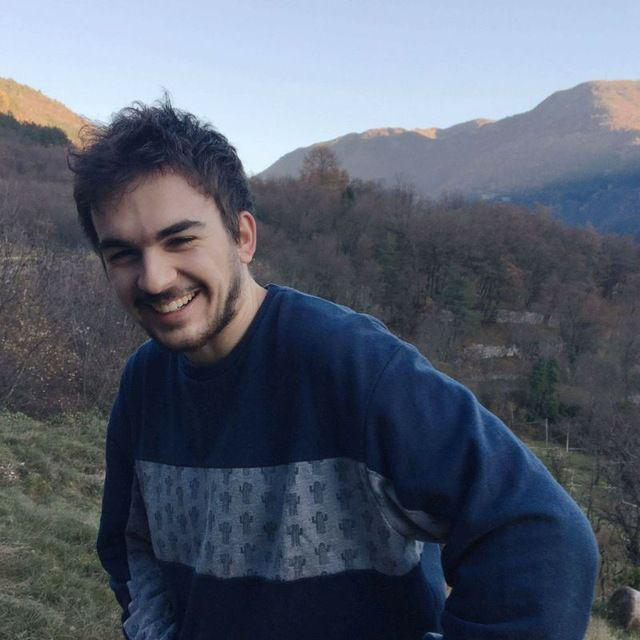

In [9]:
def show_image(id=None, img_path=None):
  """Show an image. If no path to an image or id is passed, then the image is
  retrieved at random.

    Arguments:
      id (int): id of the image to show.
      img_path (string): path to an image.
    
    Returns:
      img (JpegImageFile): image in JPG format.
  """

  # If no path to image, check the id.
  if img_path == None:
    # If no id, get a random one.
    if id == None:
      img_path = get_image()
    else:
      img_path = get_image(id=id)
  
  # Return a JpegImageFile
  return Image.open(img_path)

show_image()


## Dataset definition
In this section, we define only a dataloader for the database. Since the structure of the database is rather simple, we can simply use a `list(zip(images, annotations))` as a database in this preliminar phase.

In [10]:
# Get all of the images inside the /identities folder and their annotations.
images = glob('identities/*.jpg')
annotations = [get_annotations(image) for image in images]

# Create the dataset.
dataset = list(zip(images, annotations))


For the dataloader, we simply need a method that takes as input the dataset and returns a `DataLoader` object.

In [11]:
def get_dataloader(dataset=None, num_workers=WORKERS):
  """Return a dataloader.
  
    Arguments:
      dataset (Dataset): target of the loader. If not specified, a new dataset
        is generated automatically.
      num_workers: number of workers.
    
    Returns:
      loader (Dataloader): loader applied on the specified dataset.
  """

  # Define the collate function to use.
  def collate_fn(x):
    return x[0]
  
  # If no dataset is passed, instantiate it directly.
  if dataset == None:
    dataset = get_dataset()

  # Return the dataloader.
  return DataLoader(dataset, collate_fn=collate_fn, num_workers=WORKERS)

loader = get_dataloader(dataset)

# Model

## Model initialization
In this phase, we initialize both the facenet model and the MTCNN module.

In [12]:
from facenet_pytorch import MTCNN, InceptionResnetV1

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=IMAGE_SIZE, margin=MARGIN)

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)


Moreover, we define two methods to align images. The first one works on a simple `PIL.Image` or `numpy.array`, while the second one considers a `DataLoader` and aligns all of the images inside the dataset.

In [13]:
def align_image(img):
  """Align a single image.

    Arguments:
      img (PIL.image or numpy.ndarray (uint8)): image to align.
    
    Returns:
      aligned_img: aligned image.
  """
  try:
    # Apply the MTCNN module onto the image.
    img_aligned, prob = mtcnn(img, return_prob=True)

    # Return the aligned image.
    return img_aligned
  except:
    return None


def align_images(loader):
  """Align the images of the DataLoader.

    Arguments:
      loader (DataLoader): the loader of the images.
    
    Returns:
     aligned_data (list): contains pairs of image and name.
  """
  aligned = []
  annotations = []
  failed_aligned = []

  # Scan each element in the data loader.
  for x, y in loader:
    # Open the image.
    img = Image.open(x)

    # Try to align it.
    # NOTE: some images make MTCNN to return an error. For the moment, we are
    # not interested in the reason, therefore we simply ignore them.
    try:
      # Apply the MTCNN module onto the image.
      img_aligned, prob = mtcnn(img, return_prob=True)

      # If a face was found in the image (very probable), add its information
      # to the aligned and annotation lists.
      if img_aligned is not None:
        # print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(img_aligned)
        annotations.append(y)
    except:
      # Store the troublesome image in another list.
      failed_aligned.append(x)

  print(f'Face detected: {len(aligned)}')
  print(f'Failed align: {len(failed_aligned)}')

  return aligned, annotations


Then, we align all of the images in the dataset.

In [14]:
# Get the aligned images and their annotations.
aligned_images, aligned_images_annotations = align_images(loader)


Face detected: 4
Failed align: 0


## Inference

For this phase, we need to load the `demo.py` file. For a better understanding of its purpose, let's also use the `help` function.

In [15]:
%run demo.py
help(demo)

Help on function demo in module __main__:

demo(labelGenerator, inputFile, outputFile, detectionFPS, device)
    This 'demo' captures the inputFile and detects faces on it. Then, passes each cropped face to labelGenerator
    function and retrieves list of labels to put over that face on the original frame. The output video file will be
    saved as outputFile.
    
    Args:
        labelGenerator: function that receives a cropped face, and returns list of labels
        inputFile: path to the input video
        outputFile: path to the output video
        detectionFPS: the fps of processing faces.
        device: device name
    
    Examples:
        demo(ageEstimator,
             os.path.join(config.baseDir, 'inputSamples/Recording.mp4'),
             os.path.join(config.outputDir, 'result.avi'),
             15,
             'cpu')
    Returns:
        None



Afterward, we define the `label_generator` function, which takes a cropped image found in the current frame. This image contains a face and is evaluated against the images in the dataset. The function returns the most probable identity of the face.

In [16]:
def label_generator(cropped_image):
  # Convert cropped image from numpy to PIL.Image
  img = Image.fromarray(cropped_image.astype('uint8'))

  # Convert from BGR to RGB.
  img = Image.merge("RGB", img.split()[::-1])

  # Align the cropped image.
  img = align_image(img)

  # If the image is None, we return nothing.
  if img == None:
    return ''

  # Create the images and annotations lists.
  images = []
  images.append(img)
  images.extend(aligned_images)
  annotations = []
  annotations.append([-1, 'Unknown', -1, 'u'])
  annotations.extend(aligned_images_annotations)

  # Stack the images and move them to the available device.
  images = torch.stack(images).to(DEVICE)

  # Evaluate the images with the model.
  embeddings = resnet(images).detach().cpu()

  # Evaluate the distance between the first image and the others.
  dists = [(embeddings[0] - other).norm().item() for other in embeddings]
  dists = pd.Series(dists)
  minid = dists[dists > .01].idxmin()

  return annotations[minid][1]


In [17]:
# Generate the demo video.
demo(label_generator, 'recording.mp4', 'demo.mp4', 10, DEVICE)

Frame 2125/2125.	 Execution Time: 0.9ms	
Total Execution Time: 155357.7ms, Max Execution per Frame: 759.0ms


Finally, we show some of the frames present in the newly created video.

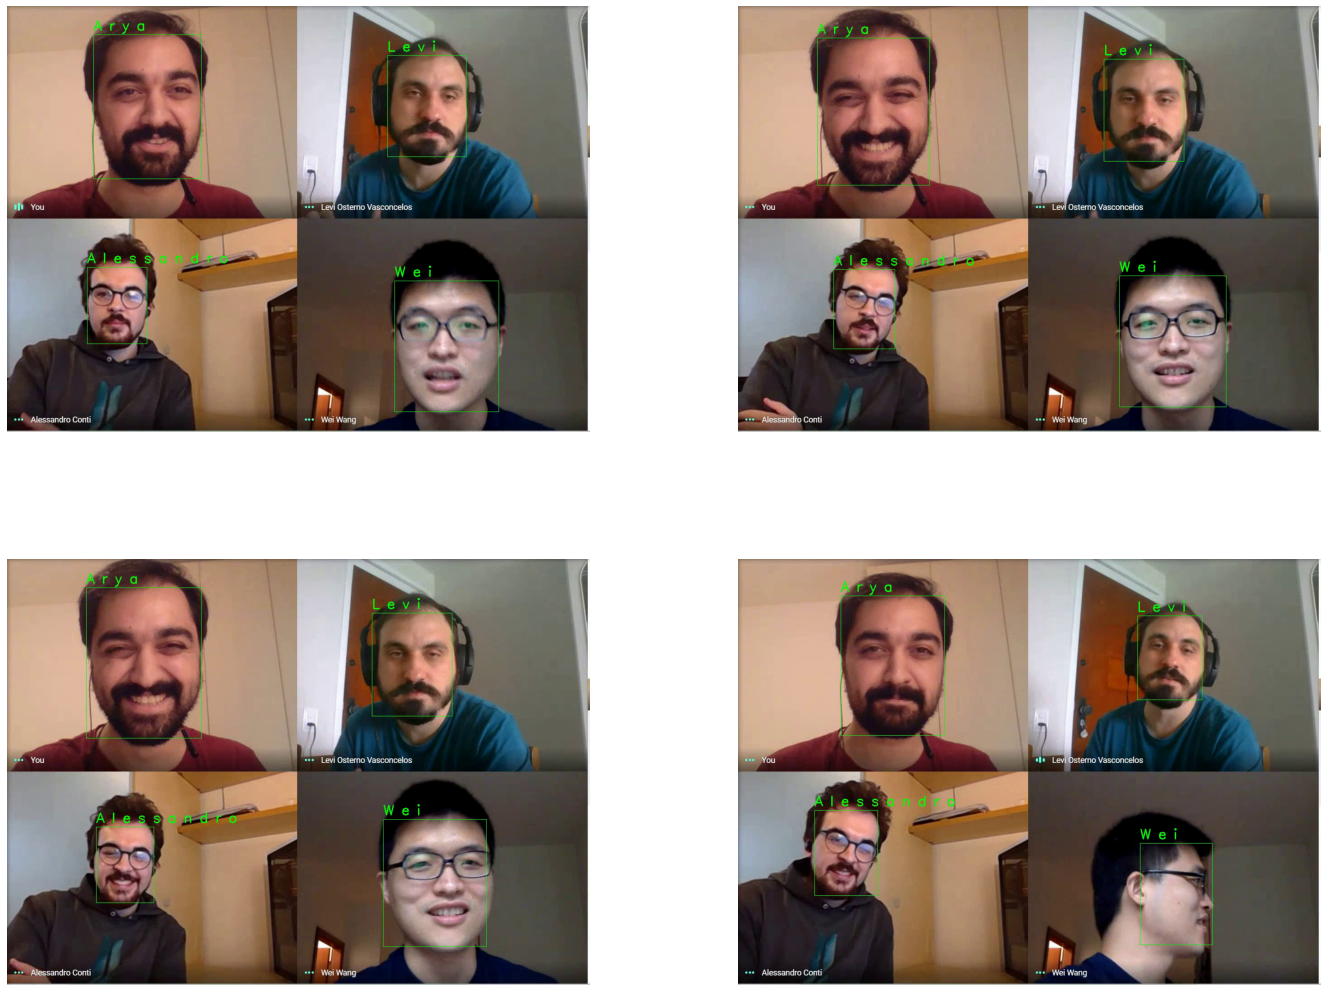

In [55]:
show_frames('demo.mp4', skip=80)

# References
We report here relevant references:
 
 1. F. Schroff, D. Kalenichenko, J. Philbin. FaceNet: A Unified Embedding for Face Recognition and Clustering, arXiv:1503.03832, 2015. https://arxiv.org/pdf/1503.03832